<a href="https://colab.research.google.com/github/Frecherenkel60/RandomForestRangers/blob/main/DataMining_RandomForestRangers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest Rangers - Predicting Car Sales Prices

In [81]:
# Install dependencies
!pip install -r requirements.txt

  Using cached pandas-2.2.3-cp310-cp310-win_amd64.whl.metadata (19 kB)
  Using cached numpy-2.1.3-cp310-cp310-win_amd64.whl.metadata (60 kB)
  Using cached matplotlib-3.9.2-cp310-cp310-win_amd64.whl.metadata (11 kB)
  Using cached scikit_learn-1.5.2-cp310-cp310-win_amd64.whl.metadata (13 kB)
INFO: pip is looking at multiple versions of contourpy to determine which version is compatible with other requirements. This could take a while.
  Using cached contourpy-1.3.1-cp310-cp310-win_amd64.whl.metadata (5.4 kB)
Using cached pandas-2.2.3-cp310-cp310-win_amd64.whl (11.6 MB)
Using cached numpy-2.1.3-cp310-cp310-win_amd64.whl (12.9 MB)
Using cached matplotlib-3.9.2-cp310-cp310-win_amd64.whl (7.8 MB)
Using cached scikit_learn-1.5.2-cp310-cp310-win_amd64.whl (11.0 MB)
Using cached contourpy-1.3.1-cp310-cp310-win_amd64.whl (218 kB)


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'D:\\Sonstiges\\Miniconda\\Files\\envs\\unienv\\Lib\\site-packages\\numpy\\linalg\\_umath_linalg.cp310-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing

In [83]:
dataset = pd.read_csv('./data/used_car_prices_generated.csv')
dataset_original = pd.read_csv('./data/used_car_prices_original.csv')

print(dataset.dtypes)
dataset.head(10)

id                int64
brand            object
model            object
model_year        int64
milage            int64
fuel_type        object
engine           object
transmission     object
ext_col          object
int_col          object
accident         object
clean_title      object
price           float64
dtype: object


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200.0
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999.0
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900.0
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000.0
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500.0
5,5,Audi,A6 2.0T Sport,2018,40950,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,White,–,None reported,Yes,29950.0
6,6,Audi,A8 L 3.0T,2016,62200,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,Yes,28500.0
7,7,Chevrolet,Silverado 1500 1LZ,2016,102604,E85 Flex Fuel,355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,White,Gray,None reported,Yes,12500.0
8,8,Ford,F-150 XLT,2020,38352,Gasoline,2.7L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Snowflake White Pearl Metallic,Black,None reported,Yes,62890.0
9,9,BMW,M4 Base,2015,74850,Gasoline,425.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Black,Blue,None reported,Yes,4000.0


In [84]:
# Distribution of the ext_col column, absolute and relative
ext_col_distribution = pd.DataFrame(dataset['ext_col'].value_counts())
ext_col_distribution['relative'] = ext_col_distribution['count'] / ext_col_distribution['count'].sum()
ext_col_distribution['cumulative'] = ext_col_distribution['relative'].cumsum()
ext_col_distribution.head(15)


,count,relative,cumulative
ext_col,,,
Black,81028,0.257868,0.257868
White,73040,0.232446,0.490314
Gray,42193,0.134277,0.624591
Silver,28343,0.090200,0.714792
Blue,24272,0.077245,0.792036
Red,16548,0.052663,0.844699
Green,4556,0.014499,0.859199
Gold,2838,0.009032,0.868231
Brown,1920,0.006110,0.874341


In [85]:
print(dataset['ext_col'].value_counts()/len(dataset))

ext_col
Black                                 0.257868
White                                 0.232446
Gray                                  0.134277
Silver                                0.090200
Blue                                  0.077245
                                        ...   
Granite Crystal Metallic Clearcoat    0.000025
BLUE                                  0.000022
Nautical Blue Pearl                   0.000022
Mango Tango Pearlcoat                 0.000016
GT SILVER                             0.000016
Name: count, Length: 319, dtype: float64


In [86]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314223 entries, 0 to 314222
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            314223 non-null  int64  
 1   brand         314223 non-null  object 
 2   model         314223 non-null  object 
 3   model_year    314223 non-null  int64  
 4   milage        314223 non-null  int64  
 5   fuel_type     305757 non-null  object 
 6   engine        314223 non-null  object 
 7   transmission  314223 non-null  object 
 8   ext_col       314223 non-null  object 
 9   int_col       314223 non-null  object 
 10  accident      310139 non-null  object 
 11  clean_title   278565 non-null  object 
 12  price         188533 non-null  float64
dtypes: float64(1), int64(3), object(9)
memory usage: 31.2+ MB


In [103]:
dataset_original

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,51000.0,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,34742.0,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,22372.0,Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,88900.0,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,9835.0,Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"
...,...,...,...,...,...,...,...,...,...,...,...,...
4004,Bentley,Continental GT Speed,2023,714.0,Gasoline,6.0L W12 48V PDI DOHC Twin Turbo,8-Speed Automatic with Auto-Shift,C / C,Hotspur,None reported,Yes,"$349,950"
4005,Audi,S4 3.0T Premium Plus,2022,10900.0,Gasoline,349.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,"$53,900"
4006,Porsche,Taycan,2022,2116.0,NaN,Electric,Automatic,Black,Black,None reported,NaN,"$90,998"
4007,Ford,F-150 Raptor,2020,33000.0,Gasoline,450.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Black,None reported,Yes,"$62,999"


In [ ]:
dataset_original.info()

# Price to 

# Change milage, to float64
dataset_original['milage'] = dataset_original['milage'].str.replace(' mi.', '').str.replace(',', '').astype('float64') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         4009 non-null   object
 1   model         4009 non-null   object
 2   model_year    4009 non-null   int64 
 3   milage        4009 non-null   object
 4   fuel_type     3839 non-null   object
 5   engine        4009 non-null   object
 6   transmission  4009 non-null   object
 7   ext_col       4009 non-null   object
 8   int_col       4009 non-null   object
 9   accident      3896 non-null   object
 10  clean_title   3413 non-null   object
 11  price         4009 non-null   object
dtypes: int64(1), object(11)
memory usage: 376.0+ KB


In [106]:
dataset[dataset['price'] == dataset['price'].min()]

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
758,758,Pontiac,Firebird Trans Am,2001,150000,Gasoline,310.0HP 5.7L 8 Cylinder Engine Gasoline Fuel,A/T,Black,Beige,None reported,Yes,2000.0
3681,3681,Toyota,Camry Hybrid Base,2003,155000,Hybrid,147.0HP 2.4L 4 Cylinder Engine Gas/Electric Hy...,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,2000.0
4781,4781,Toyota,Camry Solara SLE,2001,73690,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,Black,Gray,None reported,Yes,2000.0
11146,11146,Chevrolet,Monte Carlo SS,2001,64776,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,4-Speed A/T,Gray,Black,None reported,Yes,2000.0
12655,12655,Mercedes-Benz,SLK-Class SLK320,2003,107000,Gasoline,215.0HP 3.2L V6 Cylinder Engine Gasoline Fuel,5-Speed A/T,Black,Black,None reported,Yes,2000.0
17482,17482,GMC,Terrain SLT-1,2003,90000,Gasoline,181.0HP 2.5L 4 Cylinder Engine Gasoline Fuel,5-Speed A/T,Blue,Beige,None reported,Yes,2000.0
17849,17849,Acura,MDX Touring,2007,116000,Gasoline,260.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Gray,Brown,At least 1 accident or damage reported,Yes,2000.0
18918,18918,Ford,Dakota SLT Quad Cab,2002,138000,Gasoline,220.0HP 4.6L 8 Cylinder Engine Gasoline Fuel,A/T,Blue,Gray,None reported,Yes,2000.0
19305,19305,Mitsubishi,Eclipse Spyder GT,2003,120000,Gasoline,260.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,At least 1 accident or damage reported,Yes,2000.0
22415,22415,Lincoln,Town Car Signature,2003,120000,Gasoline,239.0HP 4.6L 8 Cylinder Engine Gasoline Fuel,4-Speed A/T,Black,Gray,None reported,Yes,2000.0


In [88]:
dataset_original.head(10)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,51000.0,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,34742.0,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,22372.0,Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,88900.0,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,9835.0,Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"
5,Acura,ILX 2.4L,2016,136397.0,Gasoline,2.4 Liter,F,Silver,Ebony.,None reported,NaN,"$14,798"
6,Audi,S3 2.0T Premium Plus,2017,84000.0,Gasoline,292.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,Blue,Black,None reported,Yes,"$31,000"
7,BMW,740 iL,2001,242000.0,Gasoline,282.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,A/T,Green,Green,None reported,Yes,"$7,300"
8,Lexus,RC 350 F Sport,2021,23436.0,Gasoline,311.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,6-Speed A/T,Black,Black,None reported,Yes,"$41,927"
9,Tesla,Model X Long Range Plus,2020,34000.0,NaN,534.0HP Electric Motor Electric Fuel System,A/T,Black,Black,None reported,Yes,"$69,950"


In [93]:
# Intersection between the two datasets to check duplicates
duplicate_rows = dataset.merge(dataset_original, how='inner', on=['brand', 'model', 'model_year', 'milage'])
print('Number of duplicate rows:', len(duplicate_rows))


Number of duplicate rows: 15189


In [ ]:
duplicate_rows

,id,brand,model,model_year,milage,fuel_type_x,engine_x,transmission_x,ext_col_x,int_col_x,...,clean_title_x,price_x,fuel_type_y,engine_y,transmission_y,ext_col_y,int_col_y,accident_y,clean_title_y,price_y
0,12,Cadillac,Escalade ESV Platinum,2017,93971,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Black,...,Yes,51500.0,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,A/T,White,Beige,None reported,Yes,"$47,000"
1,38,Mercedes-Benz,C-Class C 300 4MATIC Sport,2016,67289,Gasoline,241.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Beige,...,Yes,28000.0,Gasoline,241.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Gray,None reported,Yes,"$20,490"
2,64,BMW,M5 Base,2013,61145,Gasoline,560.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Black,...,Yes,36800.0,Gasoline,560.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Beige,At least 1 accident or damage reported,Yes,"$37,500"
3,103,Mercedes-Benz,AMG GT AMG GT S,2016,9738,Gasoline,503.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,Gray,Black,...,Yes,62500.0,Gasoline,503.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,Red,Black,None reported,Yes,"$85,500"
4,213,BMW,X5 PHEV xDrive45e,2023,3099,Plug-In Hybrid,389.0HP 3.0L Straight 6 Cylinder Engine Plug-I...,8-Speed Automatic,Black,Black,...,Yes,73897.0,Plug-In Hybrid,389.0HP 3.0L Straight 6 Cylinder Engine Plug-I...,8-Speed A/T,Black,Black,None reported,Yes,"$74,995"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15184,314053,INFINITI,QX60 Luxe,2019,51000,Gasoline,295.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Gray,Beige,...,Yes,NaN,Gasoline,295.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,CVT Transmission,Gray,–,At least 1 accident or damage reported,Yes,"$29,000"
15185,314090,Nissan,Frontier SL,2011,103400,Gasoline,261.0HP 4.0L V6 Cylinder Engine Gasoline Fuel,5-Speed A/T,Gray,Gray,...,Yes,NaN,Gasoline,261.0HP 4.0L V6 Cylinder Engine Gasoline Fuel,5-Speed A/T,Gray,Gray,At least 1 accident or damage reported,Yes,"$17,000"
15186,314172,Ford,F-150 Platinum,2018,92000,Gasoline,365.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Black,Black,...,Yes,NaN,Diesel,250.0HP 3.0L V6 Cylinder Engine Diesel Fuel,10-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$36,500"
15187,314173,Ford,Bronco Big Bend Advanced,2023,12000,Gasoline,275.0HP 2.3L 4 Cylinder Engine Gasoline Fuel,10-Speed A/T,Gray,–,...,Yes,NaN,Gasoline,275.0HP 2.3L 4 Cylinder Engine Gasoline Fuel,10-Speed A/T,Black,–,None reported,Yes,"$54,000"


In [96]:
duplicate_rows['id']

0            12
1            38
2            64
3           103
4           213
          ...  
15184    314053
15185    314090
15186    314172
15187    314173
15188    314204
Name: id, Length: 15189, dtype: int64

In [97]:
# Drop all samples which have the same brand, model, model_year and milage as 
dataset = dataset[~dataset['id'].isin(duplicate_rows['id'])]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299142 entries, 0 to 314222
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            299142 non-null  int64  
 1   brand         299142 non-null  object 
 2   model         299142 non-null  object 
 3   model_year    299142 non-null  int64  
 4   milage        299142 non-null  int64  
 5   fuel_type     291472 non-null  object 
 6   engine        299142 non-null  object 
 7   transmission  299142 non-null  object 
 8   ext_col       299142 non-null  object 
 9   int_col       299142 non-null  object 
 10  accident      295337 non-null  object 
 11  clean_title   265639 non-null  object 
 12  price         179459 non-null  float64
dtypes: float64(1), int64(3), object(9)
memory usage: 32.0+ MB


In [102]:
dataset_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         4009 non-null   object 
 1   model         4009 non-null   object 
 2   model_year    4009 non-null   int64  
 3   milage        4009 non-null   float64
 4   fuel_type     3839 non-null   object 
 5   engine        4009 non-null   object 
 6   transmission  4009 non-null   object 
 7   ext_col       4009 non-null   object 
 8   int_col       4009 non-null   object 
 9   accident      3896 non-null   object 
 10  clean_title   3413 non-null   object 
 11  price         4009 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 376.0+ KB


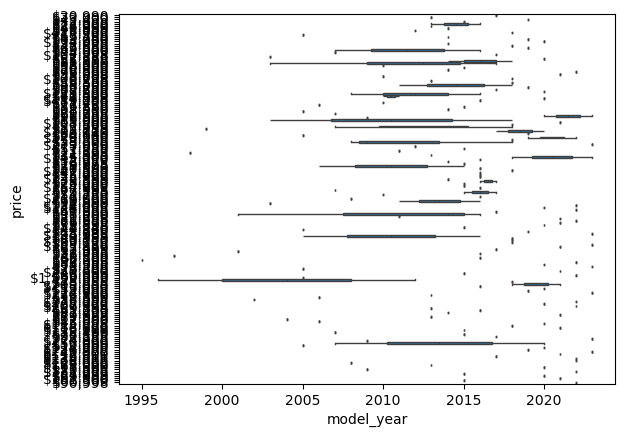

In [101]:
# Porsche subset
subset_porsche = dataset_original[dataset_original['brand'] == 'Porsche']
# Make Boxplot over the price of the Porsche subset over years
sns.boxplot(x='model_year', y='price', data=subset_porsche)
plt.show()

## Preprocessing
### Ensure consistent data formatting

In [17]:
df = dataset.copy()

# Function to reformat numeric attributes with non-numeric elements such as currency symbols
def reformat_non_numeric(text):
    if not isinstance(text, object):
        return float(text)
    return float(re.sub(r'[^\d.]', '', text))

# Function to reformat the clean title column
def reformat_clean_title(text):
    return 1 if text == 'Yes' else 0

# Function to reformat the accident column
def reformat_accident(text):
    return 0 if text == '' or text == 'None reported' else 1

# Reformat the existing columns
df['clean_title'] = df['clean_title'].apply(reformat_clean_title)
df['price'] = df['price'].apply(reformat_non_numeric)
df['milage'] = df['milage'].apply(reformat_non_numeric)
df['accident'] = df['accident'].apply(reformat_accident)

dataset = df.copy()

### Extract additional features

In [18]:
df = dataset.copy()

# Function to extract number of cylinders
def extract_cylinders(text):
    match = re.search(r'(\d+)\s*Cylinder', text, re.IGNORECASE)
    return int(match.group(1)) if match else None

# Function to extract horsepower
def extract_hp(text):
    match = re.search(r'(\d+(?:\.\d+)?)\s*HP', text, re.IGNORECASE)
    return float(match.group(1)) if match else None

# Function to extract cubic capacity
def extract_capacity(text):
    match = re.search(r'(\d+(?:\.\d+)?)\s*L', text, re.IGNORECASE)
    return float(match.group(1)) if match else None

# Function to extract whether the car has a turbo
def extract_turbo(text):
    match = re.search(r'Turbo', text, re.IGNORECASE)
    return 1 if match else 0

# Function to extract gear type
def extract_gear_type(text):
    match_automatic = re.search(r'Automatic|A/T', text, re.IGNORECASE)
    match_manual = re.search(r'Manual|M/T', text, re.IGNORECASE)
    return 'Automatic' if match_automatic else 'Manual' if match_manual else None

# Function to extract the number of gears
def extract_gears(text):
    match = re.search(r'(\d+)-Speed\b', text, re.IGNORECASE)
    return int(match.group(1)) if match else None

# Function to extract whether the car has dual shift
def extract_dual_shift(text):
    match = re.search(r'Dual Shift', text, re.IGNORECASE)
    return 1 if match else 0

# Apply the extraction functions to create new columns
df['cylinders'] = df['engine'].apply(extract_cylinders)
df['horsepower'] = df['engine'].apply(extract_hp)
df['cubic_capacity'] = df['engine'].apply(extract_capacity)
df['turbo'] = df['engine'].apply(extract_turbo)
df['gear_type'] = df['transmission'].apply(extract_gear_type)
df['gears'] = df['transmission'].apply(extract_gears)
df['dual_shift'] = df['transmission'].apply(extract_dual_shift)

dataset = df.copy()

In [19]:
# Missing values per feature only print if there are any
missing_values = dataset.isnull().sum()
missing_values = missing_values[missing_values > 0]
print('Missing values per feature:')
if not missing_values.empty:
    print(missing_values)

# Fill in missing values with the median
dataset['cylinders'] = dataset['cylinders'].fillna(dataset['cylinders'].median())
dataset['horsepower'] = dataset['horsepower'].fillna(dataset['horsepower'].median())
dataset['cubic_capacity'] = dataset['cubic_capacity'].fillna(dataset['cubic_capacity'].median())
dataset['gears'] = dataset['gears'].fillna(dataset['gears'].median())

# Fill in missing values with extra category
dataset['gear_type'] = dataset['gear_type'].fillna('N/A')
dataset['gear_type'] = dataset['gear_type'].fillna('N/A')

# Print first 10 columns
dataset.head(10)

Missing values per feature:
fuel_type          170
cylinders          945
horsepower         808
cubic_capacity     217
gear_type          489
gears             1853
dtype: int64


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,cylinders,horsepower,cubic_capacity,turbo,gear_type,gears,dual_shift
0,Ford,Utility Police Interceptor Base,2013,51000.0,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,1,1,10300.0,6.0,300.0,3.7,0,Automatic,6.0,0
1,Hyundai,Palisade SEL,2021,34742.0,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,1,1,38005.0,6.0,310.0,3.8,0,Automatic,8.0,0
2,Lexus,RX 350 RX 350,2022,22372.0,Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,0,0,54598.0,6.0,310.0,3.5,0,Automatic,7.0,0
3,INFINITI,Q50 Hybrid Sport,2015,88900.0,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,0,1,15500.0,6.0,354.0,3.5,0,Automatic,7.0,0
4,Audi,Q3 45 S line Premium Plus,2021,9835.0,Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,0,0,34999.0,6.0,310.0,2.0,1,Automatic,8.0,0
5,Acura,ILX 2.4L,2016,136397.0,Gasoline,2.4 Liter,F,Silver,Ebony.,0,0,14798.0,6.0,310.0,2.4,0,N/A,7.0,0
6,Audi,S3 2.0T Premium Plus,2017,84000.0,Gasoline,292.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,Blue,Black,0,1,31000.0,4.0,292.0,2.0,0,Automatic,6.0,0
7,BMW,740 iL,2001,242000.0,Gasoline,282.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,A/T,Green,Green,0,1,7300.0,8.0,282.0,4.4,0,Automatic,7.0,0
8,Lexus,RC 350 F Sport,2021,23436.0,Gasoline,311.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,6-Speed A/T,Black,Black,0,1,41927.0,6.0,311.0,3.5,0,Automatic,6.0,0
9,Tesla,Model X Long Range Plus,2020,34000.0,NaN,534.0HP Electric Motor Electric Fuel System,A/T,Black,Black,0,1,69950.0,6.0,534.0,3.5,0,Automatic,7.0,0


## Some interesting plots and insights from the dataset

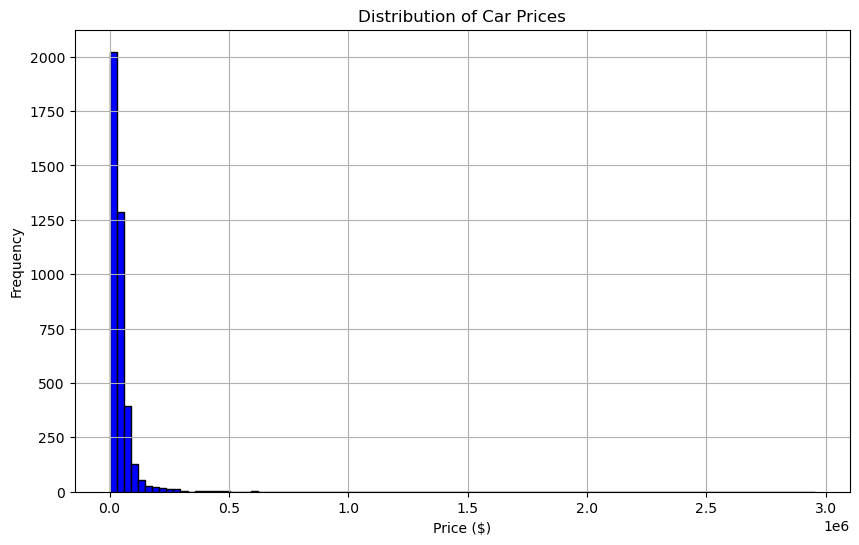

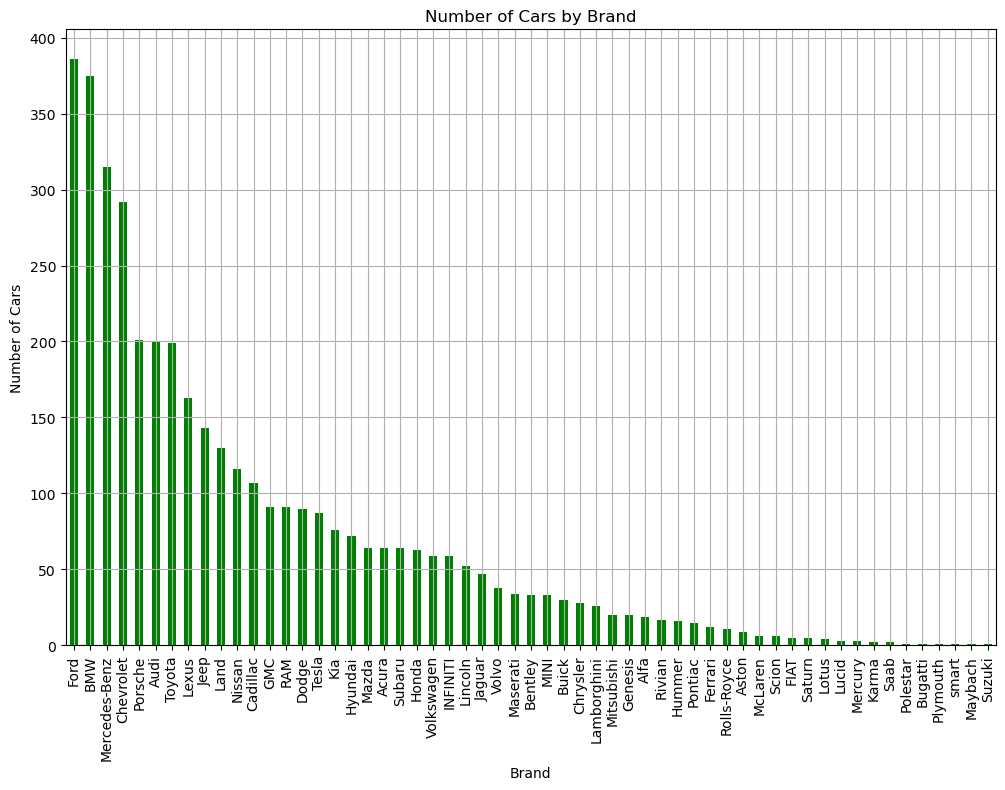

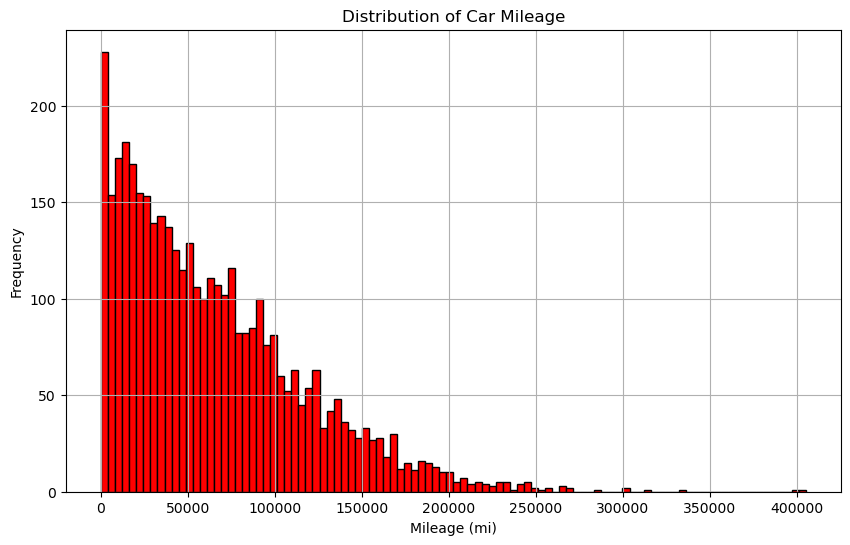

In [20]:
# Plot distribution of car prices
plt.figure(figsize=(10, 6))
plt.hist(dataset['price'].dropna(), bins=100, color='blue', edgecolor='black')
plt.title('Distribution of Car Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot number of cars by brand
plt.figure(figsize=(12, 8))
dataset['brand'].value_counts().plot(kind='bar', color='green')
plt.title('Number of Cars by Brand')
plt.xlabel('Brand')
plt.ylabel('Number of Cars')
plt.grid(True)
plt.show()

# Plot distribution of mileage
plt.figure(figsize=(10, 6))
plt.hist(dataset['milage'].dropna(), bins=100, color='red', edgecolor='black')
plt.title('Distribution of Car Mileage')
plt.xlabel('Mileage (mi)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


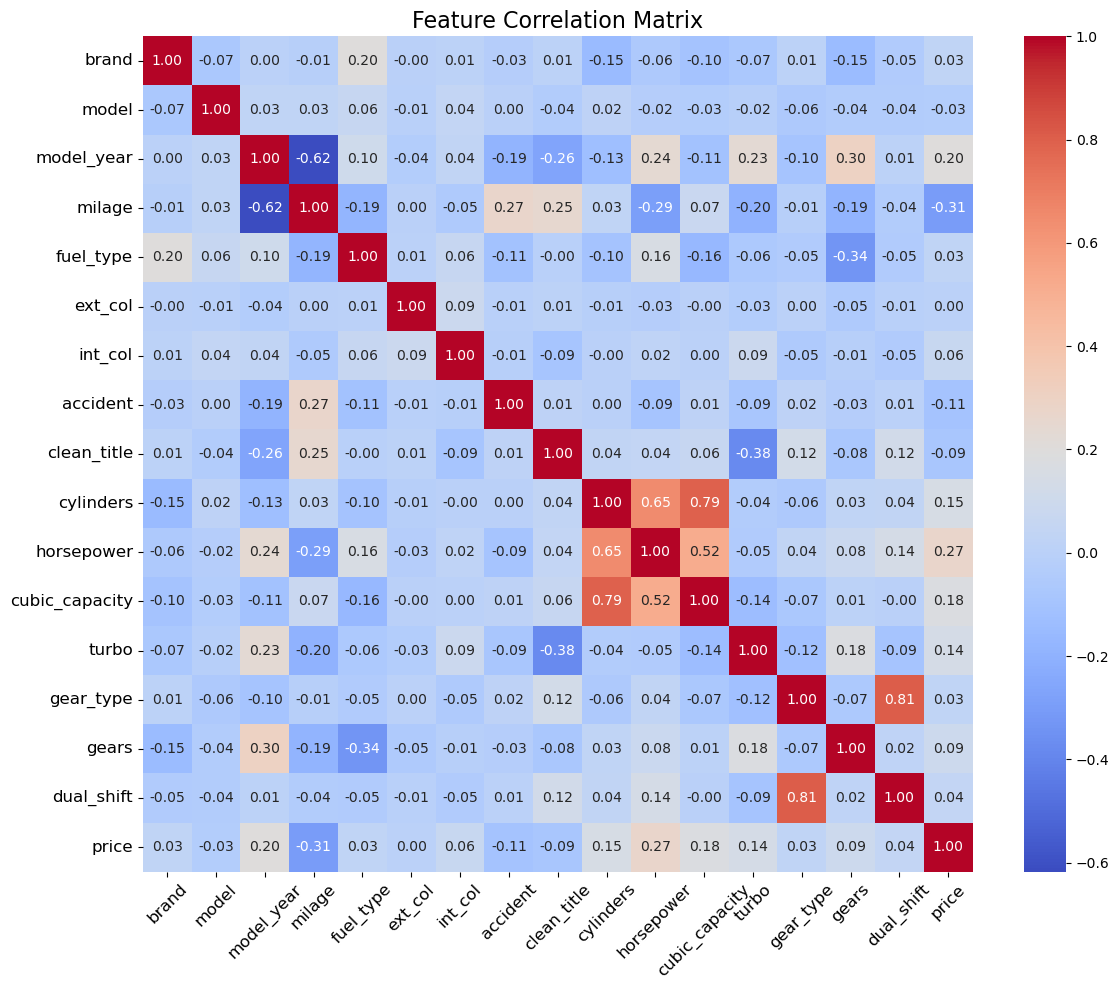

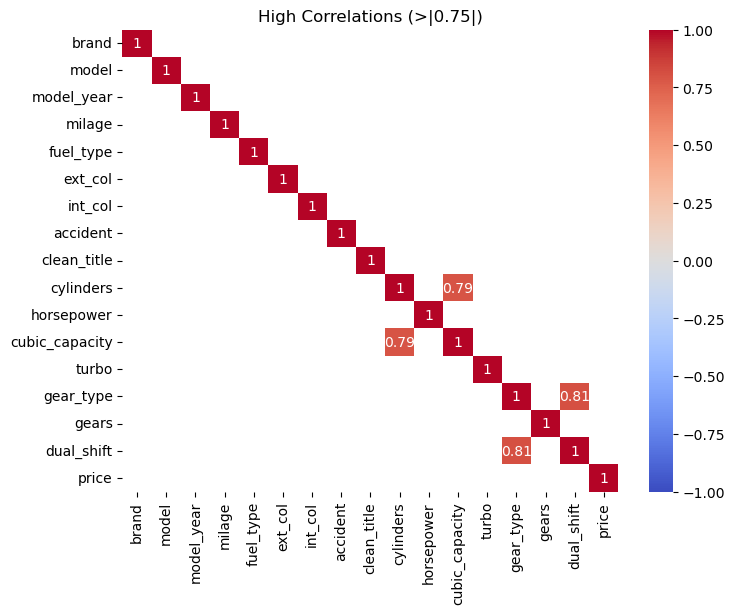

In [21]:
# Prepare data for models
dataset = dataset[[
    'brand',
    'model',
    'model_year',
    'milage',
    'fuel_type',
    'ext_col',
    'int_col',
    'accident',
    'clean_title',
    'cylinders',
    'horsepower',
    'cubic_capacity',
    'turbo',
    'gear_type',
    'gears',
    'dual_shift',
    'price'
]]
# Encode categorical variables using label encoding
label_encoders = {}
for column in dataset.select_dtypes(include=['object']).columns:
    label_encoders[column] = preprocessing.LabelEncoder()
    dataset[column] = label_encoders[column].fit_transform(dataset[column])
    dataset[column] = label_encoders[column].fit_transform(dataset[column])

# Correlation matrix
correlation_matrix = dataset.corr()
plt.figure(figsize=(12, 10))  # Adjust the width and height
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix', fontsize=16)  # Increase title font size
plt.xticks(fontsize=12, rotation=45)  # Adjust tick font size and rotate labels
plt.yticks(fontsize=12)
plt.tight_layout()  # Ensure everything fits
plt.show()

# Only high correlations above 0,8
threshold = 0.75
mask = np.abs(correlation_matrix) < threshold
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    mask=mask,
    cmap='coolwarm',
    cbar=True,
    vmin=-1, vmax=1
)
plt.title("High Correlations (>|0.75|)")
plt.show()

The attributes `dual_shift` and `gear_type` are highly correlated (seems like a lot of the transmissions have the same `dual_shift` and `gear_type` attribute in `transmission`), one of them should definitely be removed. Same goes for `cubic_capacity` and `cylinders`, which were derived from `engine`.

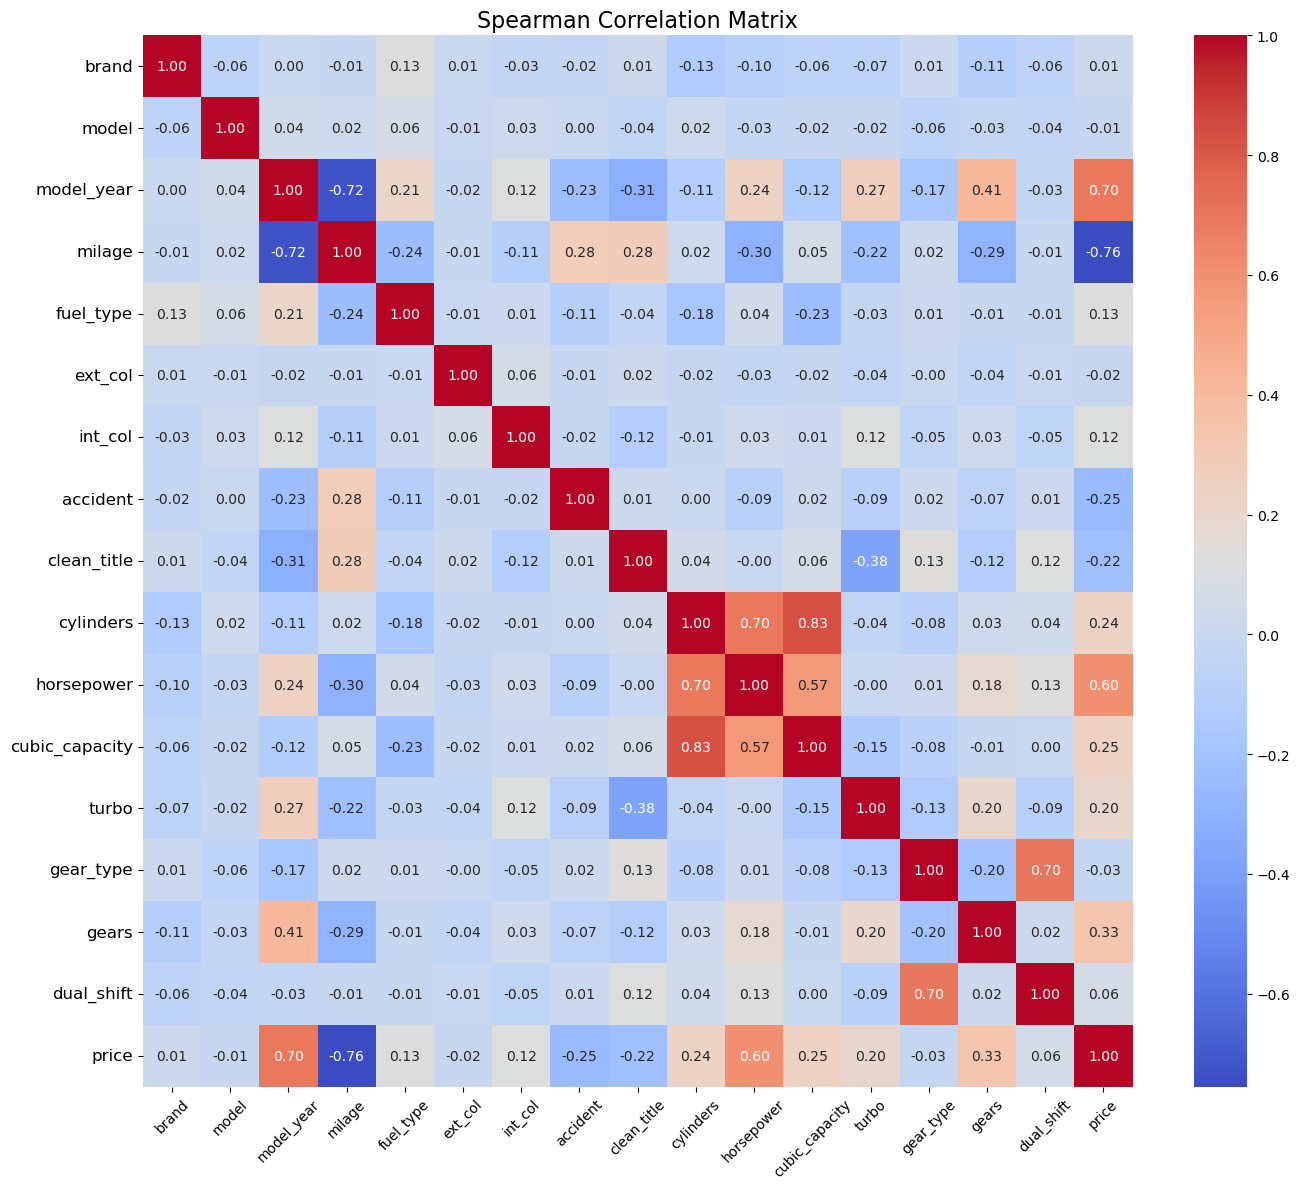

In [22]:
# Spearman correlation
spearman_correlation = dataset.corr(method='spearman')
plt.figure(figsize=(14, 12))
sns.heatmap(spearman_correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Spearman Correlation Matrix', fontsize=16)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [23]:
# Model unique values
print('Unique values for each column:')
for column in dataset.columns:
    print(f'{column}: {dataset[column].nunique()}')
    print(50 * '-')

Unique values for each column:
brand: 57
--------------------------------------------------
model: 1898
--------------------------------------------------
model_year: 34
--------------------------------------------------
milage: 2818
--------------------------------------------------
fuel_type: 8
--------------------------------------------------
ext_col: 319
--------------------------------------------------
int_col: 156
--------------------------------------------------
accident: 2
--------------------------------------------------
clean_title: 2
--------------------------------------------------
cylinders: 7
--------------------------------------------------
horsepower: 348
--------------------------------------------------
cubic_capacity: 61
--------------------------------------------------
turbo: 2
--------------------------------------------------
gear_type: 3
--------------------------------------------------
gears: 9
--------------------------------------------------
dual_shif

ext_col
29     905
304    816
128    496
263    374
38     349
      ... 
6        1
185      1
266      1
64       1
50       1
Name: count, Length: 319, dtype: int64

## Train Test Fold Split

In [65]:
from sklearn.model_selection import KFold

# Define the features and target variable
X = dataset.drop(columns=['price'])
y = dataset['price']

# Define the number of folds
k = 5

# Initialize KFold
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

print('X_train_fold shape:', X_train_fold.shape)
print('X_test_fold shape:', X_test_fold.shape)

X_train_fold shape: (3208, 16)
X_test_fold shape: (801, 16)


## Model Training
### Linear Regression

In [81]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Initialize the model
lr_model = LinearRegression()
scaler = StandardScaler()

# Data structure to store the results
benchmark_lr_models = []
best_lr_model = None

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Scale the data
    #X_train_fold_scaled = scaler.fit_transform(X_train_fold, y_train_fold)
    #X_test_fold_scaled = scaler.transform(X_test_fold)
    X_train_fold_scaled = pd.DataFrame(scaler.fit_transform(X_train_fold), columns=X_train_fold.columns)
    X_test_fold_scaled = pd.DataFrame(scaler.transform(X_test_fold), columns=X_test_fold.columns)

    # Train the model
    lr_model.fit(X_train_fold_scaled, y_train_fold)

    # Make predictions
    y_lr_pred = lr_model.predict(X_test_fold_scaled)

    # Calculate metrics
    lr_mse = mean_squared_error(y_test_fold, y_lr_pred)
    lr_r2 = r2_score(y_test_fold, y_lr_pred)

    benchmark_lr_models.append({
        'MSE': lr_mse,
        'R2': lr_r2
    })

    if not best_lr_model or lr_mse < best_lr_model['MSE']:
        best_lr_model = {
            'model': lr_model,
            'X_train': X_train_fold_scaled,
            'X_test': X_test_fold_scaled,
            'y_train': y_train_fold,
            'y_test': y_test_fold,
            'MSE': lr_mse,
            'R2': lr_r2
        }

# Convert results to DataFrame
benchmark_lr_models_df = pd.DataFrame(benchmark_lr_models)

# round mean values to 2 decimal places
print('Mean MSE :', round(benchmark_lr_models_df['MSE'].mean(), 2))
print('Mean R2:', round(benchmark_lr_models_df['R2'].mean(), 2))

print('Best model MSE:', round(best_lr_model['MSE'], 2))
print('Best model R2:', round(best_lr_model['R2'], 2))

Mean MSE : 5286054095.76
Mean R2: 0.25
Best model MSE: 1421677821.23
Best model R2: 0.33


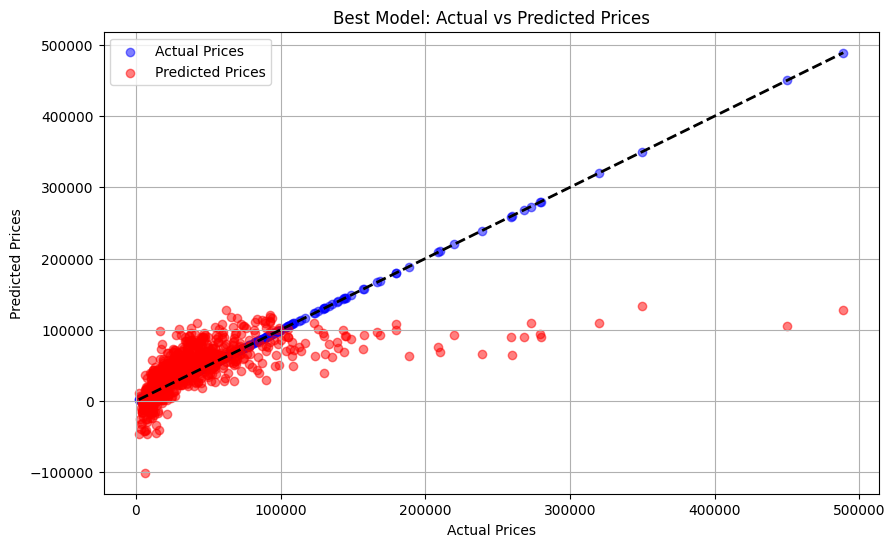

In [83]:
# Scatter plot for the best model
plt.figure(figsize=(10, 6))

# Plot actual test points
plt.scatter(best_lr_model['y_test'], best_lr_model['y_test'], color='blue', alpha=0.5, label='Actual Prices')

# Plot predicted points
plt.scatter(best_lr_model['y_test'], best_lr_model['model'].predict(best_lr_model['X_test']), color='red', alpha=0.5, label='Predicted Prices')

# Add a reference line
plt.plot([best_lr_model['y_test'].min(), best_lr_model['y_test'].max()], [best_lr_model['y_test'].min(), best_lr_model['y_test'].max()], 'k--', lw=2)

# Add a title and labels
plt.title('Best Model: Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')

# Add a legend
plt.legend()

# Add a grid
plt.grid(True)

# Show the plot
plt.show()

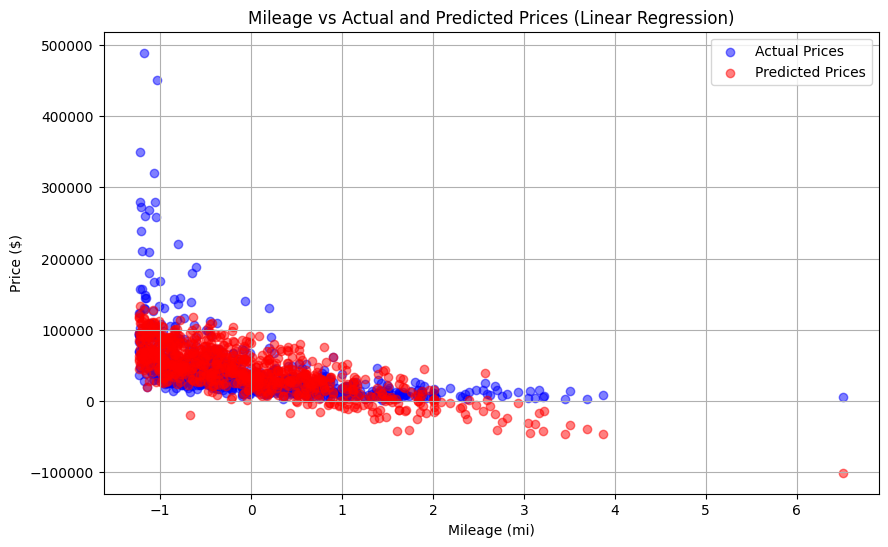

In [84]:
# Scatter plot for mileage vs actual and predicted prices using the best linear regression model
plt.figure(figsize=(10, 6))

# Plot actual prices
plt.scatter(best_lr_model['X_test']['milage'], best_lr_model['y_test'], color='blue', alpha=0.5, label='Actual Prices')

# Plot predicted prices
plt.scatter(best_lr_model['X_test']['milage'], best_lr_model['model'].predict(best_lr_model['X_test']), color='red', alpha=0.5, label='Predicted Prices')

# Add a title and labels
plt.title('Mileage vs Actual and Predicted Prices (Linear Regression)')
plt.xlabel('Mileage (mi)')
plt.ylabel('Price ($)')

# Add a legend
plt.legend()

# Add a grid
plt.grid(True)

# Show the plot
plt.show()

## Polynomial Regression

In [69]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Define the degree of the polynomial
degree = 3

# Initialize the polynomial features transformer
poly = PolynomialFeatures(degree=degree)

# Initialize the model
poly_model = LinearRegression()

# Data structure to store the results
benchmark_poly_models = []
best_poly_model = None

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Transform the features to polynomial features
    X_train_poly = poly.fit_transform(X_train_fold)
    X_test_poly = poly.transform(X_test_fold)

    # Train the model
    poly_model.fit(X_train_poly, y_train_fold)

    # Make predictions
    y_poly_pred = poly_model.predict(X_test_poly)

    # Calculate metrics
    poly_mse = mean_squared_error(y_test_fold, y_poly_pred)
    poly_r2 = r2_score(y_test_fold, y_poly_pred)

    benchmark_poly_models.append({
        'MSE': poly_mse,
        'R2': poly_r2
    })

    if not best_poly_model or poly_mse < best_poly_model['MSE']:
        best_poly_model = {
            'model': poly_model,
            'X_train': X_train_fold,
            'X_test': X_test_fold,
            'y_train': y_train_fold,
            'y_test': y_test_fold,
            'MSE': poly_mse,
            'R2': poly_r2
        }

# Convert results to DataFrame
benchmark_poly_models_df = pd.DataFrame(benchmark_poly_models)

# round mean values to 2 decimal places
print('Mean MSE :', round(benchmark_poly_models_df['MSE'].mean(), 2))
print('Mean R2:', round(benchmark_poly_models_df['R2'].mean(), 2))

print('Best model MSE:', round(best_poly_model['MSE'], 2))
print('Best model R2:', round(best_poly_model['R2'], 2))

Mean MSE : 6919746109.3
Mean R2: -0.54
Best model MSE: 3523228786.45
Best model R2: -0.12


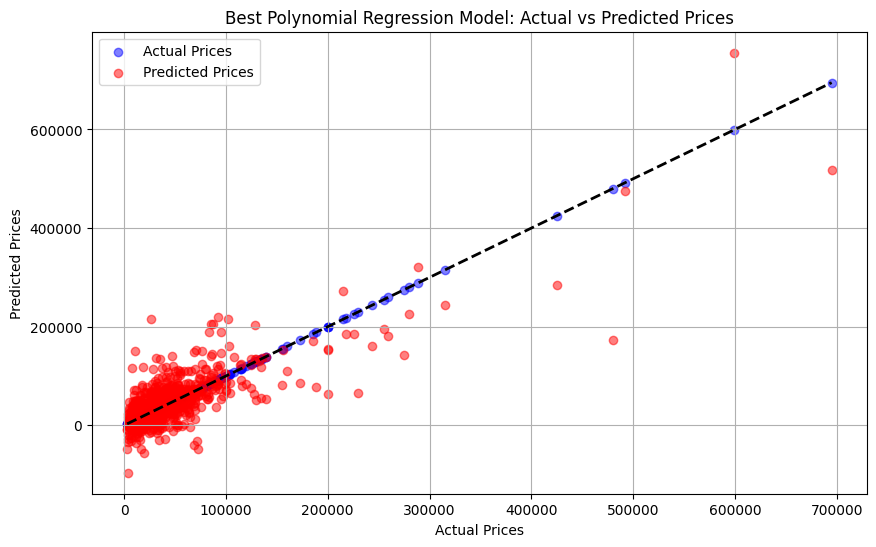

In [70]:
# Scatter plot for the best polynomial regression model
plt.figure(figsize=(10, 6))

# Plot actual test points
plt.scatter(best_poly_model['y_test'], best_poly_model['y_test'], color='blue', alpha=0.5, label='Actual Prices')

# Plot predicted points
plt.scatter(best_poly_model['y_test'], best_poly_model['model'].predict(poly.transform(best_poly_model['X_test'])), color='red', alpha=0.5, label='Predicted Prices')

# Add a reference line
plt.plot([best_poly_model['y_test'].min(), best_poly_model['y_test'].max()], [best_poly_model['y_test'].min(), best_poly_model['y_test'].max()], 'k--', lw=2)

# Add a title and labels
plt.title('Best Polynomial Regression Model: Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')

# Add a legend
plt.legend()

# Add a grid
plt.grid(True)

# Show the plot
plt.show()

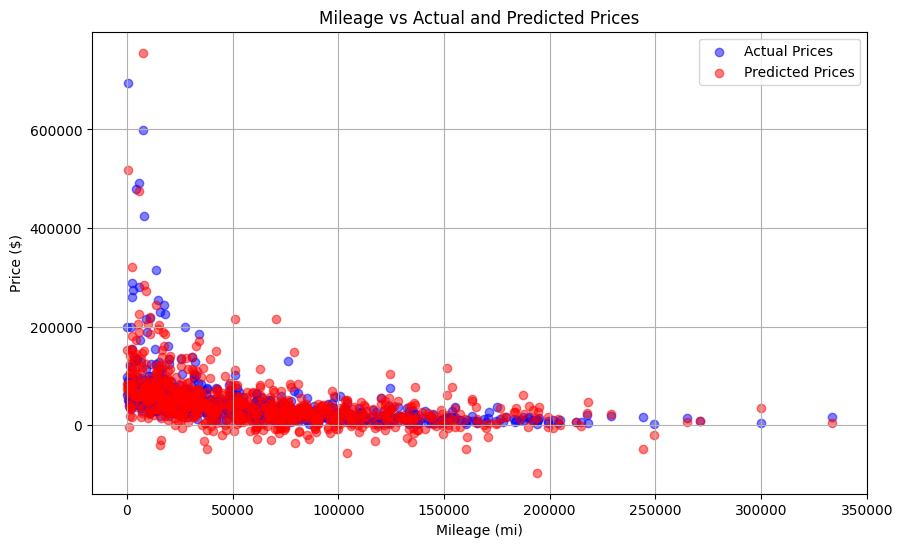

In [71]:
# Scatter plot for mileage vs actual and predicted prices using the best polynomial regression model
plt.figure(figsize=(10, 6))

# Plot actual prices
plt.scatter(best_poly_model['X_test']['milage'], best_poly_model['y_test'], color='blue', alpha=0.5, label='Actual Prices')

# Plot predicted prices
plt.scatter(best_poly_model['X_test']['milage'], best_poly_model['model'].predict(poly.transform(best_poly_model['X_test'])), color='red', alpha=0.5, label='Predicted Prices')

# Add a title and labels
plt.title('Mileage vs Actual and Predicted Prices')
plt.xlabel('Mileage (mi)')
plt.ylabel('Price ($)')

# Add a legend
plt.legend()

# Add a grid
plt.grid(True)

# Show the plot
plt.show()